 # Challenge: Boston marathon

 There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

 Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
#pd.set_option('display.max_rows', None)
import pandas_profiling as pp
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.metrics import pairwise_distances



In [2]:
# Data Source: https://github.com/llimllib/bostonmarathon/tree/master/results/2014
df = pd.read_csv("boston-marathon.csv")
pp.ProfileReport(df, check_correlation=True)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: Us

Number of variables,21
Number of observations,31984
Total Missing (%),5.0%
Total size in memory,5.1 MiB
Average record size in memory,168.0 B
Numeric,4
Categorical,14
Boolean,0
Date,0
Text (Unique),1
Rejected,2


In [3]:
df['5k'] = np.where(df['5k'] == '-' , 0, df['5k']).astype(float)
df['10k'] = np.where(df['10k'] == '-' , 0, df['10k']).astype(float)
df['20k'] = np.where(df['20k'] == '-' , 0, df['20k']).astype(float)
df['half'] = np.where(df['half'] == '-' , 0, df['half']).astype(float)
df['25k'] = np.where(df['25k'] == '-' , 0, df['25k']).astype(float)
df['30k'] = np.where(df['30k'] == '-' , 0, df['30k']).astype(float)
df['35k'] = np.where(df['35k'] == '-' , 0, df['35k']).astype(float)
df['40k'] = np.where(df['40k'] == '-' , 0, df['40k']).astype(float)
df['gender'] = np.where(df['gender'] == 'M', 1, 0)
# Cleaning: Fill NaNs
values_to_fill = {
    'state': 'Other',
    'ctz': 'NA'
    }
df = df.fillna(value=values_to_fill)

#pp.ProfileReport(df, check_correlation=False)

In [4]:
# feature eng

# Define X
X = df.drop(columns=[
                    'name', # has a high cardinality: 31915 distinct values
                    'city', # is categorical 
                    'country', # is categorical 
                    'ctz', # is categorical 
                    'state', # is categorical 
                    'bib' # is categorical 
                    ])
X = pd.concat([X, pd.get_dummies(df['city'], dtype=int)], axis=1)
X = pd.concat([X, pd.get_dummies(df['country'], dtype=int)], axis=1)
X = pd.concat([X, pd.get_dummies(df['ctz'], dtype=int)], axis=1)
X = pd.concat([X, pd.get_dummies(df['state'], dtype=int)], axis=1)


In [5]:
from sklearn.model_selection import train_test_split
# Normalize the data.
X_norm = normalize(X)

#Divide into training and test sets.
X_train, X_test = train_test_split(
    X_norm,
    test_size=0.8,
    random_state=42)

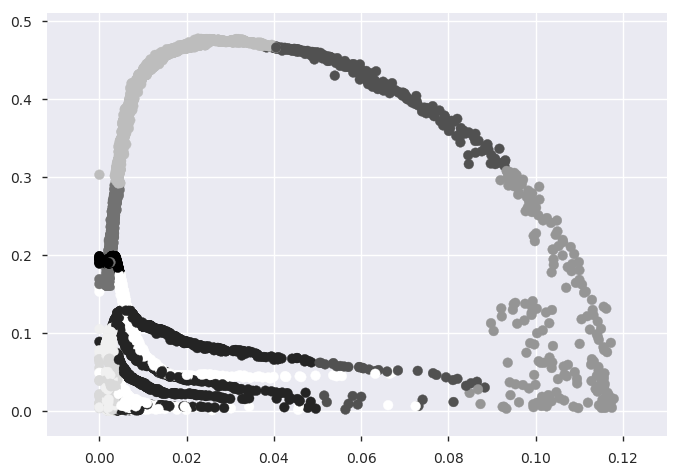

silhouette score 0.5547540498390577


In [6]:
from sklearn.cluster import KMeans
# Calculate predicted values.
km = KMeans(n_clusters=9, random_state=42).fit(X_train)
y_pred = km.predict(X_test)

# Plot the solution.
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.show()

print('silhouette score', metrics.silhouette_score(X_test, y_pred, metric='euclidean'))


Number of estimated clusters: 4


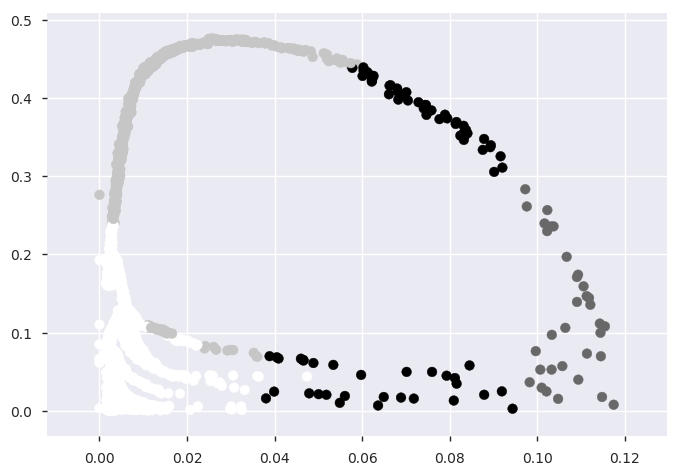

silhouette score 0.5176890109415087


In [7]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('silhouette score', metrics.silhouette_score(X_train, labels, metric='euclidean'))


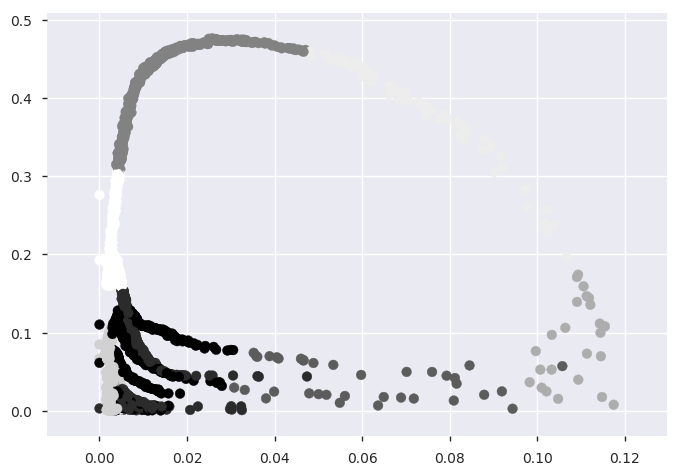

silhouette score 0.4295312013025735


In [8]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=8

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('silhouette score', metrics.silhouette_score(X_train, predict, metric='euclidean'))


In [9]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))



Done
Estimated number of clusters: 4803


/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


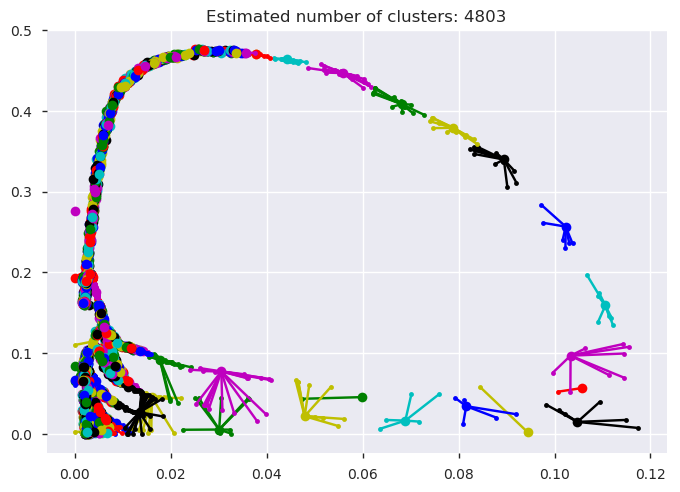

In [10]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()



 ### Best model: K-Means with k = 9
 Join our y_pred to the input X so we can learn something about the clusters

In [12]:
X_train, X_test = train_test_split(
    X,
    test_size=0.8,
    random_state=42)
df_cluster = X_test.copy()
df_cluster['cluster'] = pd.Series(y_pred)

In [13]:
df_cluster.groupby(['cluster', 'gender'])['division'].count()


cluster  gender
0.00     0          797
         1          955
1.00     0         2003
         1         2550
2.00     0         1883
         1         2347
3.00     0          790
         1          988
4.00     0           63
         1           82
5.00     0          755
         1          944
6.00     0          105
         1          122
7.00     0         1345
         1         1586
8.00     0         1427
         1         1787
Name: division, dtype: int64

 #### Group by cluster and gender to see how many female and male runners belong to each cluster
 Finding: All clusters have a similar female/mal distribution

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


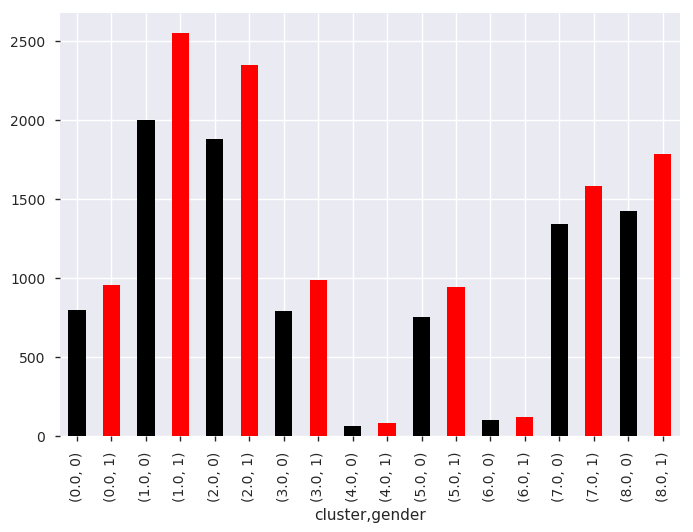

In [14]:
df_cluster.groupby(['cluster','gender']).count()['division'].plot.bar(color=['black', 'red', 'black', 'red','black', 'red', 'black', 'red', 'black', 'red', 'black', 'red','black', 'red', 'black', 'red', 'black', 'red'])

 #### Group by cluster and plot the average age
 Finding: Age is almost the same in every cluster

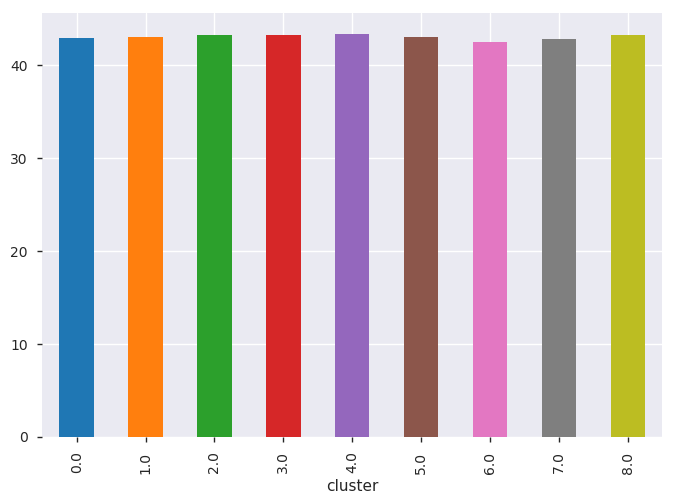

In [15]:
df_cluster.groupby(['cluster'])['age'].mean().plot.bar()